### Decoy Effect

<span style="color:yellow">
To be decided:<br>

### Prompts:

- Use contextual prompting to query both scenarios after another?<br>
    - Sticks to original study, but Decoy Effect is not applied like that in the real world.<br>
    <br>
- If not: Even mention removal of decoy in the second prompt? -> mimics original study design & shows if answers tend to approximate uniform distribution
    - Is this already a sort of priming? <br>
<br>
------------------
- Maybe set n globally and not in each run_decoy call<br>
<br>
- Huge deviations in runtime of cells: 50x5 function calls for GPT-3.5-Turbo can take ~5 min up to ~120 min (24.11.2023)<br>
<br>
- Rewrite decoy function to also count X, Q, Y? Or stick to two functions to avoid miscount. 
</span>


This notebook aims to recreate some findings concerning the **Decoy Effect**. Specifically, we recreate the event described in https://thestrategystory.com/2020/10/02/economist-magazine-a-story-of-clever-decoy-pricing/ with numbers taken from https://en.wikipedia.org/wiki/Decoy_effect.

As of right now (25.11.2023), querying each prompt 50 times for 5 temperature values over 8 prompts and the two openai 2 models, we issue **4000 API calls**. 

The answer options for this experiment are literal copies of the original study. Only the words "priced at __$" were added to each option. Furthermore, their wording remains the same
through the entire experiment, being: 
-  A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
-  B: One-year subscription to the print edition of The Economist, priced at 125$.
-  C: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.


#### From Ariely's Book "Predictably irrational":

"When I gave these options to 100 students at MIT's Sloan
School of Management, they opted as follows:
1. Internet-only subscription for $59—16 students
2. Print-only subscription for $125—zero students
3. Print-and-Internet subscription for $ 125—84 students"

(page 5)

"And the absence of the decoy
had them choosing differently, with 32 for print-and-Internet
and 68 for Internet-only"

(page 6)

|Answer option          | Scenario 1 | Scenario 2 (no 2nd option)|
|-----------------------|--------------|-----------|
| Online subscription   |     16%      |  68%       |
| Print subscribtion    |      0%     | 0%        |
| Combination           |     84%   | 32%        |



In [1]:
from openai import OpenAI
import openai
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd

In [2]:
# Get API key (previously saved as environmental variable)
openai.api_key = os.environ["OPENAI_API_KEY"]

# Set client
client = OpenAI()

# Set global plot style
plt.style.use('seaborn-v0_8')

# Set plots to be displayed in notebook
%matplotlib inline

-----------------------------------------------------------

#### Setting up the prompts used for the experiment

We now formulate 8 different prompts: 

First of all, we present the model with the original situation i.e. 3 answer options. To recreate the second scenario of the study, we tell the model that the second (decoy) option has now been removed. 
Furthermore we **prime** the model play the role of a marker researcher, who knows about the decoy effect, and query the model with both study situationbs again.

Afterwards, in order to research possible biases induced by either the answer letters themselves (A, B, C) or the order of the answers, we correct for this and prompt the model 4 times again.

- Prompt 1: Unprimed & all answer options

In [3]:
prompt_1 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
        A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
        B: One-year subscription to the print edition of The Economist, priced at 125$.
        C: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
        Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
        Answer: I would choose option """


- Prompt 2: Unprimed & second option (decoy) removed

In [4]:
prompt_2 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
        A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
        B: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$. 
        Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
        Answer: I would choose option """

# Removed original option B and made option C the new option B

- Prompt 3: Primed & all answer options

In [5]:
prompt_3 = """You are a market researcher that knows about the Decoy Effect in pricing. 
        You are presented with the following subscription alternatives for the "The Economist" magazine:
        A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
        B: One-year subscription to the print edition of The Economist, priced at 125$.
        C: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
        Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
        Answer: I would choose option """


- Prompt 4: Primed & second option (decoy) removed

In [30]:
prompt_4 = """You are a market researcher that knows about the Decoy Effect in pricing. 
         You are presented with the following subscription alternatives for the "The Economist" magazine:
         A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
         B: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
         Answer: I would choose option """

# Removed original option B and made option C the new option B

---------------------

#### Renaming and reordering answer options

Following the approach of Mendler-Dünner et al. (2023), we do not only reorder the answers but also label them with letters, that are less common in the English language.
- A (online) -> Y
- B (print) -> Q
- C (combination) -> X

Afterwards option 1 is put last. Sticking to our original question design, the order would now be: B, C, A.
- N (print)
- T (combination)
- W (online)

**-> Use decoy_function2() for these prompts!**

- Prompt 5: Unprimed & all answer options, renamed & reordered

In [7]:
prompt_5 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
         Q: One-year subscription to the print edition of The Economist, priced at 125$.
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
         Answer: I would choose option """


- Prompt 6: Unprimed & second option (decoy) removed, renamed & reordered

In [8]:
prompt_6 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
         Answer: I would choose option """

# Removed option Q

- Prompt 7: Primed & all answer options, renamed & reordered

In [9]:
prompt_7 = """You are a market researcher that knows about the Decoy Effect in pricing. 
         You are presented with the following subscription alternatives for the "The Economist" magazine:
         Q: One-year subscription to the print edition of The Economist, priced at 125$.
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
         Answer: I would choose option """

- Prompt 8: Primed & second option (decoy) removed, renamed & reordered

In [29]:
# Temoprarily adjusted answer optionds to QXY 
prompt_8 = """You are a market researcher that knows about the Decoy Effect in pricing. 
         You are presented with the following subscription alternatives for the "The Economist" magazine:
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.
         Answer: I would choose option """

# Removed option Q

------------------------------------------

- Helpful dictionaries 

The experiments we will run in this notebook are very similar in study design, and for same cases, also similar in the results we expect. We therefore need to make sure, that we associate the results with the correct study design. That is why the following dictionaries are implemented to look up e.g. what model was used for an experiment.

They will also be used inside the functions that call the API multiple times and output some information about the experiment in order to identify it correctly. 

In [25]:
# Dictionary that returns the literal prompt for a given experiment id (used in function call). key: experiment_id, value: prompt
experiment_prompts_dict = {
    "1_1": prompt_1,
    "1_2": prompt_2,
    "1_3": prompt_3,
    "1_4": prompt_4,
    "1_5": prompt_5,
    "1_6": prompt_6,
    "1_7": prompt_7,
    "1_8": prompt_8,
    "2_1": prompt_1,
    "2_2": prompt_2,
    "2_3": prompt_3,
    "2_4": prompt_4,
    "2_5": prompt_5,
    "2_6": prompt_6,
    "2_7": prompt_7,
    "2_8": prompt_8,
}

# The following dictionary is only used for a check in the function calls.
# It returns the variable name of the prompt that was used in the experiment. key: experiment_id, value: prompt_name
prompt_ids_dict = {
    "1_1": "prompt_1",
    "1_2": "prompt_2",
    "1_3": "prompt_3",
    "1_4": "prompt_4",
    "1_5": "prompt_5",
    "1_6": "prompt_6",
    "1_7": "prompt_7",
    "1_8": "prompt_8",
    "2_1": "prompt_1",
    "2_2": "prompt_2",
    "2_3": "prompt_3",
    "2_4": "prompt_4",
    "2_5": "prompt_5",
    "2_6": "prompt_6",
    "2_7": "prompt_7",
    "2_8": "prompt_8",
}


# Dictionary to look up which model to use for a given experiment id (used in function call). key: experiment id, value: model name
model_dict = {
    "1_1": "gpt-3.5-turbo",
    "1_2": "gpt-3.5-turbo",
    "1_3": "gpt-3.5-turbo",
    "1_4": "gpt-3.5-turbo",
    "1_5": "gpt-3.5-turbo",
    "1_6": "gpt-3.5-turbo",
    "1_7": "gpt-3.5-turbo",
    "1_8": "gpt-3.5-turbo",
    "2_1": "gpt-4-1106-preview",
    "2_2": "gpt-4-1106-preview",
    "2_3": "gpt-4-1106-preview",
    "2_4": "gpt-4-1106-preview",
    "2_5": "gpt-4-1106-preview",
    "2_6": "gpt-4-1106-preview",
    "2_7": "gpt-4-1106-preview",
    "2_8": "gpt-4-1106-preview",
    }


# Dictionary to look up, what the study design of each experiment was. key: experiment id, value: experiment design 
experiment_dict = {
    "1_1": f"Experiment 1_1 contains all answer options, is unprimed and uses {model_dict['1_1']}.",
    "1_2": f"Experiment 1_2 has the decoy removed, is unprimed and uses {model_dict['1_2']}.",
    "1_3": f"Experiment 1_3 contains all answer options, is primed and uses {model_dict['1_3']}.",
    "1_4": f"Experiment 1_4 has the decoy removed, is primed and uses {model_dict['1_4']}.",
    "1_5": f"Experiment 1_5 contains all answer options renamed and reordered, is unprimed and uses {model_dict['1_5']}.",
    "1_6": f"Experiment 1_6 has the decoy removed, answer options renamed and reordered, is unprimed and uses {model_dict['1_6']}.",
    "1_7": f"Experiment 1_7 contains all answer options renamed and reordered, is primed and uses {model_dict['1_7']}.",
    "1_8": f"Experiment 1_8 has the decoy removed, answer options renamed and reordered, is primed and uses {model_dict['1_8']}.",
    "2_1": f"Experiment 2_1 contains all answer options, is unprimed and uses {model_dict['2_1']}.",
    "2_2": f"Experiment 2_2 has the decoy removed, is unprimed and uses {model_dict['2_2']}.",
    "2_3": f"Experiment 2_3 contains all answer options, is primed and uses {model_dict['2_3']}.",
    "2_4": f"Experiment 2_4 has the decoy removed, is primed and uses {model_dict['2_4']}.",
    "2_5": f"Experiment 2_5 contains all answer options renamed and reordered, is unprimed and uses {model_dict['2_5']}.",
    "2_6": f"Experiment 2_6 has the decoy removed, answer options renamed and reordered, is unprimed and uses {model_dict['2_6']}.",
    "2_7": f"Experiment 2_7 contains all answer options renamed and reordered, is primed and uses {model_dict['2_7']}.",
    "2_8": f"Experiment 2_8 has the decoy removed, answer options renamed and reordered, is primed and uses {model_dict['2_8']}.",
}

# Dictionary to look up the original results of the experiments. key: experiment id, value: original result
results_dict = {
    "1_1": "A: 16%, B: 0%, C: 84%",
    "1_2": "A: 68%, B: 0%, C: 32%",
    "1_3": "A: 16%, B: 0%, C: 84%",
    "1_4": "A: 68%, B: 0%, C: 32%",
    "1_5": "A: 16%, B: 0%, C: 84%",
    "1_6": "A: 68%, B: 0%, C: 32%",
    "1_7": "A: 16%, B: 0%, C: 84%",
    "1_8": "A: 68%, B: 0%, C: 32%",
    "2_1": "A: 16%, B: 0%, C: 84%",
    "2_2": "A: 68%, B: 0%, C: 32%",
    "2_3": "A: 16%, B: 0%, C: 84%",
    "2_4": "A: 68%, B: 0%, C: 32%",
    "2_5": "A: 16%, B: 0%, C: 84%",
    "2_6": "A: 68%, B: 0%, C: 32%",
    "2_7": "A: 16%, B: 0%, C: 84%",
    "2_8": "A: 68%, B: 0%, C: 32%",
}

----------------------------------------------

#### Test-wise function

The following functions are implemented test-wise with the goal of discarding the decoy_function2 and keeping the workflow more general. Depending on what the experiment id is, answers will be counted according to the survey design. 

In some prompts, answer options are removed while in others, they are renamed. Using the count_answers() function, we make the results more easily comparable, since p(A), p(B) and p(C) will always reflect the probabilty of the underlying answer text being chosen, not the letter of the answer option itself. 

In [12]:
def count_answers(answers: list, experiment_id: str):
    if experiment_id in ["1_1", "1_3","2_1", "2_3"]:
        A = answers.count("A")
        B = answers.count("B")
        C = answers.count("C")
    elif experiment_id in ["1_2", "1_4", "2_2", "2_4"]:
        A = answers.count("A")
        B = 0 # Option B was removed
        C = answers.count("B") # makes comparison of results over prompts easier 
    elif experiment_id in ["1_5", "1_7", "2_5", "2_7"]:
        A = answers.count("Y")
        B = answers.count("Q")
        C = answers.count("X")
    elif experiment_id in ["1_6", "1_8", "2_6", "2_8"]:
        A = answers.count("Y")
        B = 0 # Option Q was removed
        C = answers.count("X")
    return A, B, C

def correct_answers(answers: list, experiment_id: str):
    if experiment_id in ["1_1", "1_3","2_1", "2_3"]:
        len_correct = sum(1 for ans in answers if ans in ["A", "B", "C"])
    elif experiment_id in ["1_2", "1_4", "2_2", "2_4"]:
        len_correct = sum(1 for ans in answers if ans in ["A", "B"])
    elif experiment_id in ["1_5", "1_7", "2_5", "2_7"]:
        len_correct = sum(1 for ans in answers if ans in ["Y", "Q", "X"])
    elif experiment_id in ["1_6", "1_8", "2_6", "2_8"]:
        len_correct = sum(1 for ans in answers if ans in ["Y", "X"])
    return len_correct  # to avoid division by zero

In [13]:
def run_experiment(experiment_id, n, temperature = 1, max_tokens = 1):
    """
    Function to query ChatGPT multiple times with a survey having answers designed as: A, B, C.
    
    Args:
        experiment_id (str): ID of the experiment to be run. Contains info about prompt and model
        n (int): Number of queries to be made
        temperature (int): Degree of randomness with range 0 (deterministic) to 2 (random)
        max_tokens (int): Maximum number of tokens in response object
        
    Returns:
        results (list): List containing count of answers for each option, also containing experiment_id, temperature and number of observations
        probs (list): List containing probability of each option being chosen, also containing experiment_id, temeperature and number of observations
    """
    answers = []
    for _ in range(n): 
        response = client.chat.completions.create(
            model = model_dict[experiment_id], 
            max_tokens = max_tokens,
            temperature = temperature, # range is 0 to 2
            messages = [
            {"role": "user", "content": experiment_prompts_dict[experiment_id]},
                   ])

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())

    # Count the answers
    A, B, C = count_answers(answers, experiment_id) # if/else statement of function deals with different answer options in different experiments
    
    # Count of correct answers
    len_correct = int(correct_answers(answers, experiment_id)) # if/else of function makes sure that we count the correct answers according to the experiment id 

    # Collecting results in a list
    results = [experiment_id, temperature, A, B, C, len_correct]

    # Calculate probabilities
    p_a = f"{(A / (len_correct + 0.000000001)) * 100:.2f}%"
    p_b = f"{(B / (len_correct + 0.000000001)) * 100:.2f}%"
    p_c = f"{(C / (len_correct + 0.000000001)) * 100:.2f}%"

    # Collect probabilities in a dataframe
    probs = [experiment_id, temperature, p_a, p_b, p_c, len_correct]
    # Print progress
    print(f"Experiment {experiment_id} with {n} observations, using {prompt_ids_dict[experiment_id]} and temperature {temperature} completed.")

    return results, probs 

In [16]:
def temperature_loop(experiment_id: str, temperature_list: list = [0, 0.5, 1, 1.5, 2], n: int = 50, max_tokens: int = 1):
    """
    Function to run an experiment over different temperature values.
    
    Args:
        function (function): Function to be used for querying ChatGPT i.e. run_experiment()
        experiment_id (str): ID of th e experiment to be run. Contains info about prompt and model
        temperature_list (list): List of temperature values to be looped over
        n: Number of requests for each prompt per temperature value
        max_tokens: Maximum number of tokens in response object
        
    Returns:
        results_df: Dataframe with experiment results
        probs_df: Dataframe with answer probabilities
    """    
    # Empty lists for storing results
    results_list = []
    probs_list = []
    

    # Loop over different temperature values, calling the input function n times each (i.e. queriyng ChatGPT n times)
    for temperature in temperature_list:
        results, probs = run_experiment(experiment_id = experiment_id, n = n, temperature = temperature, max_tokens = max_tokens) 
        results_list.append(results)
        probs_list.append(probs)

    # Horizontally concatenate the results, transpose, and set index
    results_df = pd.DataFrame(results_list).transpose().set_index(pd.Index(["Experiment", "Temp", "p(A)", "p(B)", "p(C)", "Obs."]))
    probs_df = pd.DataFrame(probs_list).transpose().set_index(pd.Index(["Experiment", "Temp", "p(A)", "p(B)", "p(C)", "Obs."]))
   
    # Return some information about the experiment as a check
    check = f"{experiment_dict[experiment_id]} In this run, a total of {n*len(temperature_list)} requests were made using {prompt_ids_dict[experiment_id]}."
    # Print information about the experiment
    print(check)
    # Print original results 
    print(f"The original results were {results_dict[experiment_id]}.")

    
    return results_df, probs_df

In [17]:
test_results, test_probs = temperature_loop(experiment_id = "1_4", temperature_list = [0, 0.5, 1, 1.5, 2], n = 5, max_tokens = 1)

Experiment 1_4 with 5 observations, using prompt_4 and temperature 0 completed.
Experiment 1_4 with 5 observations, using prompt_4 and temperature 0.5 completed.
Experiment 1_4 with 5 observations, using prompt_4 and temperature 1 completed.
Experiment 1_4 with 5 observations, using prompt_4 and temperature 1.5 completed.
Experiment 1_4 with 5 observations, using prompt_4 and temperature 2 completed.
Experiment 1_4 has the decoy removed, is primed and uses gpt-3.5-turbo. In this run, a total of 25 requests were made using prompt_4.
The original results were A: 68%, B: 0%, C: 32%.


In [26]:
test_results, test_probs = run_experiment(experiment_id = "1_4", n = 5, temperature = 1.0, max_tokens = 1)
test_probs

Experiment 1_4 with 5 observations, using prompt_4 and temperature 1.0 completed.


['1_4', 1.0, '0.00%', '0.00%', '100.00%', 5]

In [28]:
experiment_prompts_dict["1_4"]

'You are a market researcher that knows about the Decoy Effect in pricing. \n         You are presented with the following subscription alternatives for the "The Economist" magazine:\n         A: For 59$: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997.\n         B: For 125$: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997.\n         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning.\n         Answer: I would choose option '

-----------------------------

#### Setting up functions to repeatedly prompt ChatGPT

- Functions to query 1 prompt n times

In [184]:
def decoy_function(experiment_id, n, temperature = 1, max_tokens = 1):

    """
    Function to query ChatGPT multiple times with a survey having answers designed as: A, B, C.
    
    Args:
        experiment_id (str): ID of the experiment to be run. Contains info about prompt and model
        n (int): Number of queries to be made
        temperature (int): Degree of randomness with range 0 (deterministic) to 2 (random)
        max_tokens (int): Maximum number of tokens in response object
        
    Returns:
        results (list): List containing count of answers for each option, also containing experiment_id, temperature and number of observations
        probs (list): List containing probability of each option being chosen, also containing experiment_id, temeperature and number of observations
    """
    
    answers = []
    for _ in range(n): 
        response = client.chat.completions.create(
            model = model_dict[experiment_id], 
            max_tokens = max_tokens,
            temperature = temperature, # range is 0 to 2
            messages = [
            {"role": "user", "content": experiment_prompts_dict[experiment_id]},
                   ])

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())


    # Counting results
    A = answers.count("A")
    B = answers.count("B")
    C = answers.count("C")

    # Count of "correct" answers, sums over indicator function thack checks if answer is either A, B or C
    len_correct = sum(1 for ans in answers if ans in ["A", "B", "C"])

    # Collecting results in a list
    results = [experiment_id, temperature, A, B, C, len_correct]

    # Getting percentage each answer
    p_a = f"{(A / (len_correct + 0.000000001)) * 100:.2f}%"
    p_b = f"{(B / (len_correct + 0.000000001)) * 100:.2f}%"
    p_c = f"{(C / (len_correct + 0.000000001)) * 100:.2f}%"

    # Collect probabilities in a dataframe
    probs = [experiment_id, temperature, p_a, p_b, p_c, len_correct]
    
    # Give out results
    return answers, results, probs

In [15]:
# This function is almost identical to the original one, but deals with answer options that are renamed as A = Y, B = Q, C = X.
# We apply this "conversion" so that the results are comparable to the ones obtained with the original function.
# Prompts 5-8 are used for this function.
def decoy_function2(experiment_id, n, temperature = 1, max_tokens = 1):

    """
    Function to query ChatGPT multiple times with a survey having answers designed as: Y, Q, X.
    
    Args:
        experiment_id (str): ID of the experiment to be run. Contains info about prompt and model
        n (int): Number of queries to be made
        temperature (int): Degree of randomness with range 0 (deterministic) to 2 (random)
        max_tokens (int): Maximum number of tokens in response object
        
    Returns:
        results (list): List containing count of answers for each option, also containing experiment_id, temperature and number of observations
        probs (list): List containing probability of each option being chosen, also containing experiment_id, temeperature and number of observations
    """

    answers = []
    for _ in range(n): 
        response = client.chat.completions.create(
            model = model_dict[experiment_id], 
            max_tokens = max_tokens,
            temperature = temperature, # range is 0 to 2
            messages = [
            {"role": "user", "content": experiment_prompts_dict[experiment_id]},
                   ])

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())
    
    # Counting results
    A = answers.count("Y") ######################################### CHANGED
    B = answers.count("Q")
    C = answers.count("X")

    # Count of "correct" answers, sums over indicator function thack checks if answer is either W, N, or T
    len_correct = sum(1 for ans in answers if ans in ["Y", "Q", "X"])############################################# CHANGED
    
    # Collecting results in a list
    results = [experiment_id, temperature, A, B, C, len_correct]

    # Getting percentage each answer
    p_w = f"{(A / len_correct) * 100:.2f}%"
    p_b = f"{(B / len_correct) * 100:.2f}%"
    p_c = f"{(C / len_correct) * 100:.2f}%"

    # Collect probabilities in a dataframe
    probs = [experiment_id, temperature, p_w, p_b, p_c, len_correct] 

    # Give out results
    return answers, results, probs ############################################# CHANGED

- Function to loop over temperature values, querying each prompt n times for every temperature

In [16]:
# Function to loop decoy function over temperature values
def run_decoy(function, experiment_id, temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1):
    """
    Function to run an experiment with different temperature values.
    
    Args:
        function (function): Function to be used for querying ChatGPT i.e. run_experiment()
        experiment_id (str): ID of the experiment to be run. Contains info about prompt and model
        temperature_list (list): List of temperature values to be looped over
        n: Number of requests for each prompt per temperature value
        max_tokens: Maximum number of tokens in response object
        
    Returns:
        results_df: Dataframe with experiment results
        probs_df: Dataframe with answer probabilities
    """    
    # Empty lists for storing results
    results_list = []
    probs_list = []

    # Loop over different temperature values, calling the input function n times each (i.e. queriyng ChatGPT n times)
    for temperature in temperature_list:
        answers, results, probs = function(experiment_id = experiment_id, n = n, temperature = temperature, max_tokens = max_tokens) ############################################# CHANGED
        results_list.append(results)
        probs_list.append(probs)

    # Horizontally concatenate the results, transpose, and set index
    results_df = pd.DataFrame(results_list).transpose().set_index(pd.Index(["Experiment", "Temp", "p(A)", "p(B)", "p(C)", "Obs."]))
    probs_df = pd.DataFrame(probs_list).transpose().set_index(pd.Index(["Experiment", "Temp", "p(A)", "p(B)", "p(C)", "Obs."]))
   
    # Return some information about the experiment as a check
    check = f"In this experiment, {n} requests were made per temperature value using model {model_dict[experiment_id]} and {prompt_ids_dict[experiment_id]}."
    print(check)
    
    return results_df, probs_df

For high values of temperature we (rarely) still get "incorrect" answers i.e. not in the form of "A", "B", or "C".
Using the following approach, the computed percentages will now only reflect the distribution of answers among the "correctly" answered questions and add up to 100%:


- len_correct = sum(1 for ans in answers if ans in ["A", "B", "C"]) # instead of len(answers)


From my experience with this notebook, among 50 repeated requests for a given prompt, setting the temperature value to max (2) only 1 or 2 answers were not A, B, or C.
Therefore we can safely assume that the distribution of answers among the "correctly" answered questions is not affected by the presence of these outliers and this approach is valid.
Furthermore, for each experiment, we can still see the answer count in the results dataframe as a check.

- Function to plot distribution of answer probabilities

In [33]:
def plot_results(df):
    
    # Get experiment id and model name for plot title from dictionaries
    experiment_id = df.iloc[0, 0]
    model = model_dict[experiment_id]
    
    X = df.loc["Temp"]
    p_a = df.loc["p(A)"].str.rstrip('%').astype('float')  # Convert percentages to float
    p_b = df.loc["p(B)"].str.rstrip('%').astype('float')
    p_c = df.loc["p(C)"].str.rstrip('%').astype('float')

    X_axis = np.arange(len(X)) 

    plt.figure(figsize = (10, 5))
    ax = plt.gca()
    ax.bar(X_axis- 0.25, p_a, 0.25, label = 'p(A)', color = "#8C1515") 
    ax.bar(X_axis, p_b, 0.25,  label = 'p(B)', color = "#507FAB") 
    ax.bar(X_axis+ 0.25 , p_c,  0.25, label = 'p(C)', color = '#D9A84A')

    ax.set_xticks(X_axis, X)
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Probability (%)")
    ax.set_ylim(0, 110)
    ax.set_title(f"Distribution of answers per temperature value for experiment {experiment_id} using {model}")
    ax.legend()  
    plt.show()


---------------------

## Comparing different LLMs

The results variables will be structured as: results_model-id_prompt-id.

We will refer to "GPT-3.5-turbo" as model 1 and "GPT-4-1106-preview" as model 2.

#### Model 1: GPT-3.5-Turbo (Model training ended in September 2021)

- Simple test of repeated prompting function for fixed temperature

In [34]:
results_5, probs_5 = decoy_function(experiment_id = "2_2", n = 5, temperature = 1, max_tokens = 1)
probs_5

# experiment_id, temp, p_a, p_b, p_c (in original survey), n_observations

['2_2', 1, '0.00%', '0.00%', '100.00%', 5]

- Simple test of function to loop over temperature values

In [35]:
# Print study design to get an overview
print(experiment_dict["1_1"])

# Call the function 
results, probs = run_decoy(decoy_function, experiment_id = "1_1", temperature_list = [0, 0.5, 1, 1.5, 2], n = 3, max_tokens = 1)

# Display probability dataframe
print(probs)

Experiment 1_1 contains all answer options, is unprimed and uses gpt-3.5-turbo.
In this experiment, 3 requests were made per temperature value using model gpt-3.5-turbo and prompt_1.
                  0        1        2       3       4
Experiment      1_1      1_1      1_1     1_1     1_1
Temp            0.0      0.5      1.0     1.5     2.0
p(A)          0.00%    0.00%    0.00%   0.00%  50.00%
p(B)          0.00%    0.00%    0.00%  33.33%  50.00%
p(C)        100.00%  100.00%  100.00%  66.67%   0.00%
Obs.              3        3        3       3       2


- Prompt 1: Unprimed & all answer options

In [36]:
# Call function
results_1_1, probs_1_1 = run_decoy(decoy_function, experiment_id = "1_1", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
# Display results
probs_1_1

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_1.


,0,1,2,3,4
Experiment,1_1,1_1,1_1,1_1,1_1
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,6.00%,6.12%
p(B),0.00%,0.00%,6.00%,8.00%,14.29%
p(C),100.00%,100.00%,94.00%,86.00%,79.59%
Obs.,50,50,50,50,49


- Prompt 2: Unprimed & second option (decoy) removed

In [37]:
results_1_2, probs_1_2 = run_decoy(decoy_function, experiment_id = "1_2", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_2

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_2.


,0,1,2,3,4
Experiment,1_2,1_2,1_2,1_2,1_2
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,4.00%,18.00%,30.00%,46.81%
p(B),0.00%,0.00%,0.00%,0.00%,2.13%
p(C),100.00%,96.00%,82.00%,70.00%,51.06%
Obs.,50,50,50,50,47


- Prompt 3: Primed & all answer options

In [45]:
results_1_3, probs_1_3 = run_decoy(decoy_function, experiment_id = "1_3", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_3

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_3.


,0,1,2,3,4
Experiment,1_3,1_3,1_3,1_3,1_3
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,6.00%,2.04%,22.92%
p(B),0.00%,2.00%,16.00%,12.24%,22.92%
p(C),100.00%,98.00%,78.00%,85.71%,54.17%
Obs.,50,50,50,49,48


In [116]:
answers, results, probs = decoy_function(experiment_id = "1_3", n = 10, temperature = 2, max_tokens = 5)
answers

['B', 'C', 'C', 'B', 'C', 'C', 'C', 'A', 'C', 'B']

- Prompt 4: Primed & second option (decoy) removed

In [39]:
results_1_4, probs_1_4 = run_decoy(decoy_function, experiment_id = "1_4", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_4

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_4.


,0,1,2,3,4
Experiment,1_4,1_4,1_4,1_4,1_4
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,8.00%,18.00%,30.00%,19.57%
p(B),0.00%,0.00%,0.00%,0.00%,2.17%
p(C),100.00%,92.00%,82.00%,70.00%,78.26%
Obs.,50,50,50,50,46



-----------------------------

- Prompt 5: Unprimed & all answer options, renamed & reordered

In [40]:
results_1_5, probs_1_5 = run_decoy(decoy_function2, experiment_id = "1_5", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_5

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_5.


,0,1,2,3,4
Experiment,1_5,1_5,1_5,1_5,1_5
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,6.00%,14.29%,22.22%
p(B),0.00%,0.00%,0.00%,2.04%,0.00%
p(C),100.00%,100.00%,94.00%,83.67%,77.78%
Obs.,50,50,50,49,45


- Prompt 6: Unprimed & second option (decoy) removed, renamed & reordered

In [41]:
results_1_6, probs_1_6 = run_decoy(decoy_function2, experiment_id = "1_6", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_6

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_6.


,0,1,2,3,4
Experiment,1_6,1_6,1_6,1_6,1_6
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,10.00%,22.00%,37.50%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,90.00%,78.00%,62.50%
Obs.,50,50,50,50,48


- Prompt 7: Primed & all answer options, renamed & reordered

In [42]:
results_1_7, probs_1_7 = run_decoy(decoy_function2, experiment_id = "1_7", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_7

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_7.


,0,1,2,3,4
Experiment,1_7,1_7,1_7,1_7,1_7
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,2.00%,2.04%,7.14%
p(B),0.00%,8.00%,18.00%,36.73%,26.19%
p(C),100.00%,92.00%,80.00%,61.22%,66.67%
Obs.,50,50,50,49,42


- Prompt 8: Primed & second option (decoy) removed, renamed & reordered

In [43]:
results_1_8, probs_1_8 = run_decoy(decoy_function2, experiment_id = "1_8", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_1_8

In this experiment, 50 requests were made per temperature value using model gpt-3.5-turbo and prompt_8.


,0,1,2,3,4
Experiment,1_8,1_8,1_8,1_8,1_8
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,2.00%,8.00%,22.00%,26.19%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,98.00%,92.00%,78.00%,73.81%
Obs.,50,50,50,50,42


-------------------------------------

#### Model 2: GPT-4-1106-preview (Model training ended in April 2023)

- Prompt 1: Unprimed & all answer options

In [46]:
results_2_1, probs_2_1 = run_decoy(decoy_function, experiment_id = "2_1", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_1

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_1.


,0,1,2,3,4
Experiment,2_1,2_1,2_1,2_1,2_1
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,2.08%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,97.92%
Obs.,50,50,50,50,48


- Prompt 2: Unprimed & second option (decoy) removed

In [47]:
results_2_2, probs_2_2 = run_decoy(decoy_function, experiment_id = "2_2", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_2

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_2.


,0,1,2,3,4
Experiment,2_2,2_2,2_2,2_2,2_2
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,100.00%
Obs.,50,50,50,50,50


- Prompt 3: Primed & all answer options

In [48]:
results_2_3, probs_2_3 = run_decoy(decoy_function, experiment_id = "2_3", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_3

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_3.


,0,1,2,3,4
Experiment,2_3,2_3,2_3,2_3,2_3
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,100.00%
Obs.,50,50,50,50,49


- Prompt 4: Primed & second option (decoy) removed

In [49]:
results_2_4, probs_2_4 = run_decoy(decoy_function, experiment_id = "2_4", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_4

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_4.


,0,1,2,3,4
Experiment,2_4,2_4,2_4,2_4,2_4
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,2.00%,8.00%,10.42%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,98.00%,92.00%,89.58%
Obs.,50,50,50,50,48


-----------------------------------------

- Prompt 5: Unprimed & all answer options, renamed & reordered

In [50]:
results_2_5, probs_2_5 = run_decoy(decoy_function2, experiment_id = "2_5", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_5

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_5.


,0,1,2,3,4
Experiment,2_5,2_5,2_5,2_5,2_5
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,100.00%
Obs.,50,50,50,50,48


- Prompt 6: Unprimed & second option (decoy) removed, renamed & reordered

In [51]:
results_2_6, probs_2_6 = run_decoy(decoy_function2, experiment_id = "2_6", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_6

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_6.


,0,1,2,3,4
Experiment,2_6,2_6,2_6,2_6,2_6
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,4.00%,12.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,96.00%,88.00%
Obs.,50,50,50,50,50


- Prompt 7: Primed & all answer options, renamed & reordered

In [52]:
results_2_7, probs_2_7 = run_decoy(decoy_function2, experiment_id = "2_7", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50, max_tokens = 1)
probs_2_7

In this experiment, 50 requests were made per temperature value using model gpt-4-1106-preview and prompt_7.


,0,1,2,3,4
Experiment,2_7,2_7,2_7,2_7,2_7
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,100.00%
Obs.,50,50,50,50,45


- Prompt 8: Primed & second option (decoy) removed, renamed & reordered

In [111]:
results_2_8, probs_2_8 = run_decoy(decoy_function2, experiment_id = "2_8", temperature_list = [0, 0.5, 1, 1.5, 2], n = 20, max_tokens = 1)
probs_2_8

In this experiment, 20 requests were made per temperature value using model gpt-4-1106-preview and prompt_8.


,0,1,2,3,4
Experiment,2_8,2_8,2_8,2_8,2_8
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,15.79%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,84.21%
Obs.,20,20,20,19,19


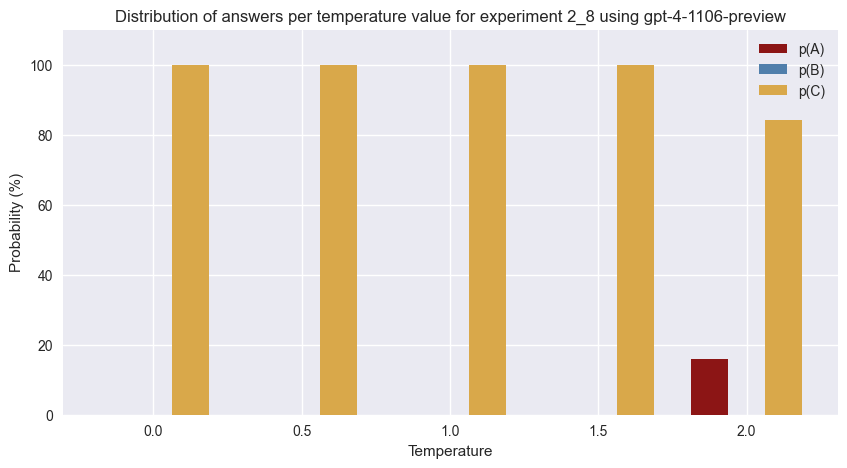

In [112]:
plot_results(probs_2_8)

In [ ]:
# Check if priming actually works
answer = []
response = client.chat.completions.create(
        model = "gpt-3.5-turbo",
        max_tokens = 100,
        temperature = 1, # range is 0 to 2
        messages = [
        {"role": "user", "content": """Do you know about the Decoy Effect?"""},
                   ])
# Store the answer in the list
answer = response.choices[0].message.content

answer

-----------------------------------------------------

Motivated by the I-bias experiment, we now examine whether labeling bias can be mitigated by using
letters that have similar frequency in written English. Therefore, instead of assigning to choices the
labels “A”, “B”, etc. we assign the following labels: “R”, “S”, “N”, “L”, “O”, “T”, “M”, “P”, “W”, “U”, “Y”,
“V” - Mendler-Dünner paper 